
(Python 3.5.2)

# Bike Demand Forecasting with Machine Learning Algorithms

### Task
Given the Bike Sharing Data set at https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset,
make an explorative data anlysis and build a prediction model for the hourly used count.

### Data (brief description)
The data set (hour.csv) contains a wide range of features such as the season, year, weathersit, humidity, etc. all associated with the count of total rental bikes including both casual and registered users.

### Modelling approach 
- Identify columns that are potentially useful features based on data visualisation and exploration
- Create new feature colums if necessary to improve alignement between the features and the target (feature engineering)
- Select the appropriate Machine Learning algorithm for the Bike Demand Forecasting  (Regression Algorithms)
- Split the data and use a portion of it to train the selected algorithm based on the selected features columns
- Examine the trained model to identify the features that appear to have the most effect on the predictive outcome
- Score the model using the data held back to compare the predicted values with known actual values
- Repeat the process, pruning features that don't appear  to be predictively important, engineering new features and selecting alternative algorithms to create alternative models
- Evaluate all the models created by comparing with one another and examine the error statistics based on predicted and known values



In [1]:
# -*- start -*-
# Import the modules

import matplotlib
#matplotlib.use('agg') 
%matplotlib inline  
import numpy as np 
import scipy as sp
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.cross_validation

from pandas.tools.plotting import scatter_matrix
import pandas.tools.rplot as rplot
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
# from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from random import randint 
from scipy.stats import uniform

import seaborn as sns
import time

import sys


import myfuncs

font = {'size':30}
plt.rc('font',**font)

C:\Users\Dekou\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Dekou\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: 
The rplot trellis plotting interface is deprecated and will be removed in a future version. We refer to external packages like seaborn for similar but more refined functionality. 

See our docs http://pandas.pydata.org/pandas-docs/stable/visualization.html#rplot for some example how to convert your existing code to these packages.
C:\Users\Dekou\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the m

### Load and explore Bike sharing datasets

In [2]:

#==============================================================================
# Loading Bike sharing dataset
#==============================================================================


Bdat1 = pd.read_csv('./hour.csv')

Bdat_f = pd.read_csv('./hour.csv') #template for feature engineering visualisation



#print(Bdat1.keys())
print(Bdat1.head(5))

#==============================================================================
#  Remove columns we're not going to use, dteday is taken into account
# in yy-mn-dd
#==============================================================================


Bdat1 = Bdat1.drop(['instant', 'dteday'], axis=1) 
 
Bdat_f = Bdat_f.drop(['instant', 'dteday'], axis=1) 

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


### Pair-Wise Scatter Plot

A pair-wise scatter plot is used to  examine the relationship between many variables in one view. It displays every combination of all variables in both possible orientations.


C:\Users\Dekou\Anaconda3\lib\site-packages\pandas\tools\plotting.py:3369: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "the passed axes is being cleared", UserWarning)


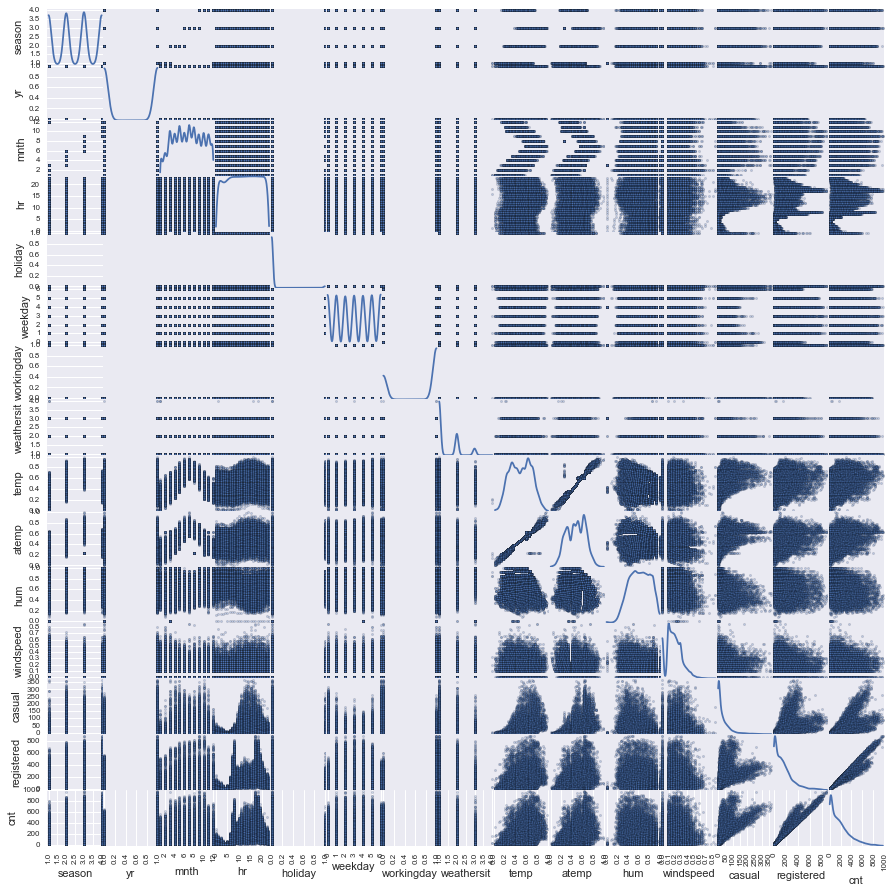

elapsed time for scat_all 1497088702.1198936


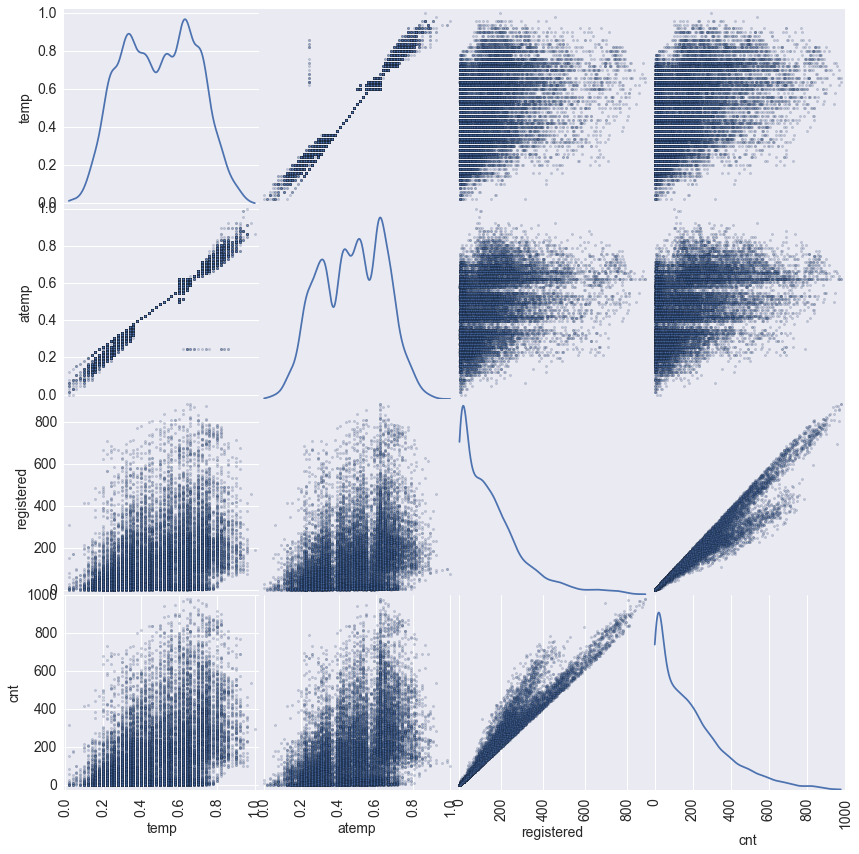

In [3]:
 
#==============================================================================
# Creating a pair wise scatter plot
#==============================================================================

 

# might take some time
tic = time.clock()

fig1 = plt.figure(1, figsize=(15, 15))
ax = fig1.gca()
scatter_matrix(Bdat1, alpha=0.3,diagonal='kde', ax = ax)
plt.show()
fig1.savefig('./figures/scatter_all.png')
plt.close()
print ('elapsed time for scat_all', time.time() -tic)



# Zoom on important plots


fig2 = plt.figure(1, figsize=(14, 14))
ax = fig2.gca()
scat = scatter_matrix(Bdat1[['temp', 'atemp', 'registered', 'cnt']],
               alpha=0.3,diagonal='kde', ax = ax)

[plt.setp(item.yaxis.get_majorticklabels(), 'size', 14) for item in
scat.ravel()]

[plt.setp(item.xaxis.get_majorticklabels(), 'size', 14) for item in
scat.ravel()]
[plt.setp(item.yaxis.get_label(), 'size', 14) for item in
scat.ravel()]
[plt.setp(item.xaxis.get_label(), 'size', 14) for item in
scat.ravel()]

plt.show()

fig2.savefig('./figures/scatter_few.png')
plt.close()


The second pair-wise scatter plot is the same as the first one. It is plotted with only few columns in order to highlight the main findings from the first plot.

In this figure, we can see that the features temp and atemp are highly correlated. It is the same for registered and  count columns which display a  diagonal line when plotted against each other. 

### Histograms and boxplots  

Histograms and boxplots of features and targets are now investigated to check if there are some outliers in the data. 

An histogram shows the frequency of occurence of the selected feature values (or target values) on the vertical axis vs bins of values on the horizontal axis.

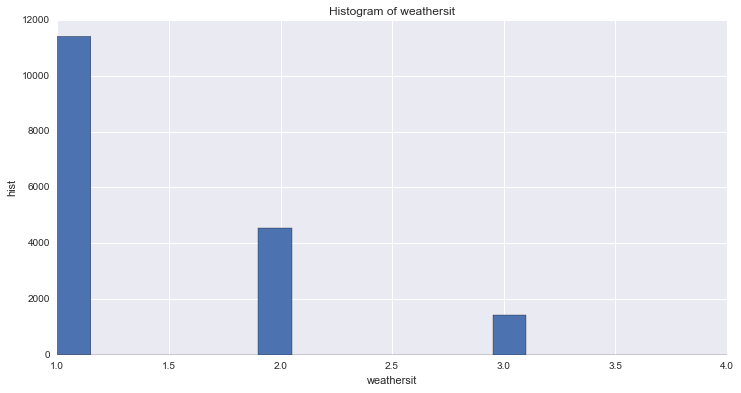

In [4]:
col_list = Bdat1.columns # store columns names

for col in Bdat1.columns:

    temp = Bdat1[col].as_matrix()

    fig = plt.figure(figsize = (12,6))
    fig.clf()

    plt.hist(temp, bins = 20)
    plt.title('Histogram of ' +col)
    plt.xlabel(col) 
    plt.ylabel('hist')

    if col == 'weathersit': # one column to illustrate
        plt.show() 
   
    plt.savefig('./figures/'+col+'_hist')

    plt.close()


As example, the histogram of the weather situation is displayed on the top figure.

We can see that the frequency of occurence of the weather situation drops monotonically from situation 1 to 4. 

Where the situations are explained as follows: 
    
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

The reader is welcome to examine the other histograms in the directory ./figures which accompagnies this notebook. 

Globally, from the histograms trends we can say that no prominent outliers were found.

Boxplots is another way to summarize the set of a database through a five number summary of this data:
min and max values, first and third quartiles and the median. 

Potential outliers lie outside of the min and max values. The box itself ranges from the 1st to the 3rd quartile meaning that 50 % of the data fall inside the box.


C:\Users\Dekou\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


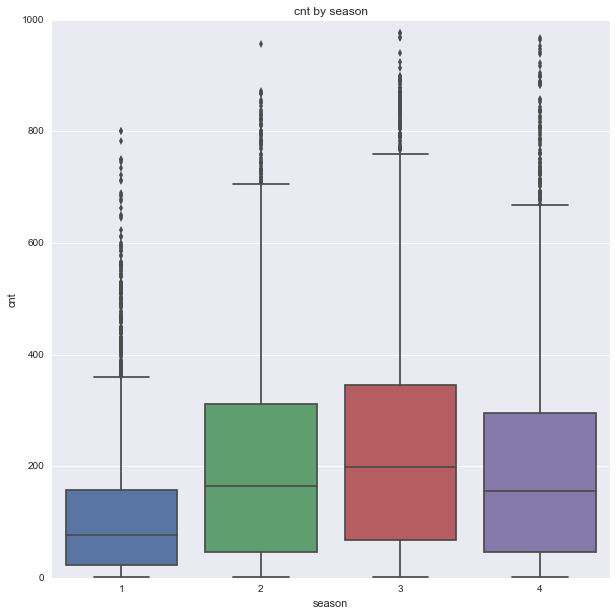

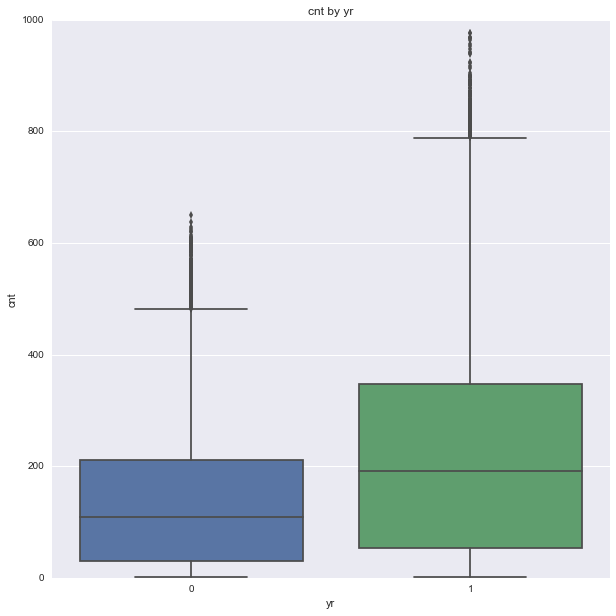

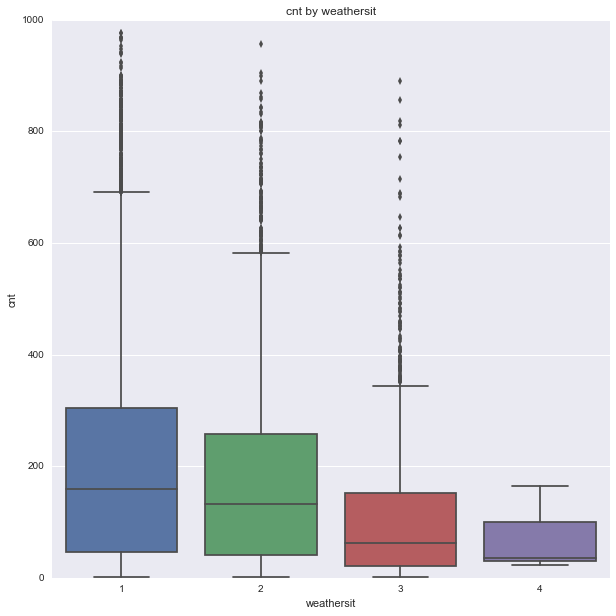

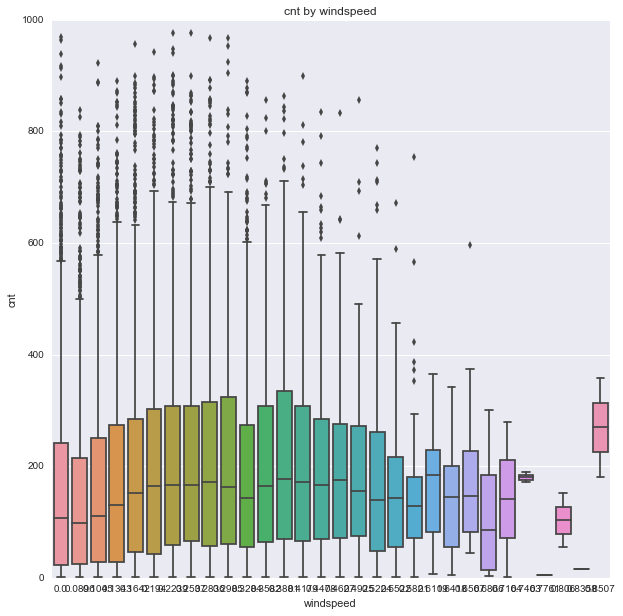

In [5]:
col_list2 = ['season', 'yr', 'weathersit',
             'windspeed', 'hr',  'holiday']  
  

for col in col_list2[:-2]:        
    
    fig = plt.figure(1, figsize=(10, 10))

      
    sns.boxplot(Bdat1.cnt, groupby = Bdat1[col])

    plt.title('cnt by '+ col)

    plt.show() 
    fig.savefig('./figures/Bplot'+col) 
    plt.close()


The top figures display boxplots of season, yr, weathersit and  windspeed respectively. 

A seasonal trend of the renting is clearly observable. The count tends to increase from year 0 (2011) to year 1 (2012) and logically, people tends to rent bikes more often in good weather situations. 

Beyond the whiskers, some potential outliers are observable. But, rather than being bias in the data,  they are correlated with specific hour ranges (0-4 and 10-15) and  holiday periods as confirmed by the plots below. 

C:\Users\Dekou\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


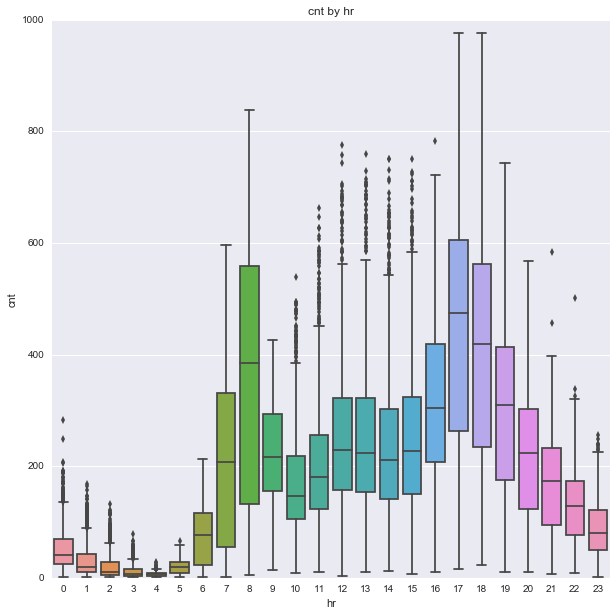

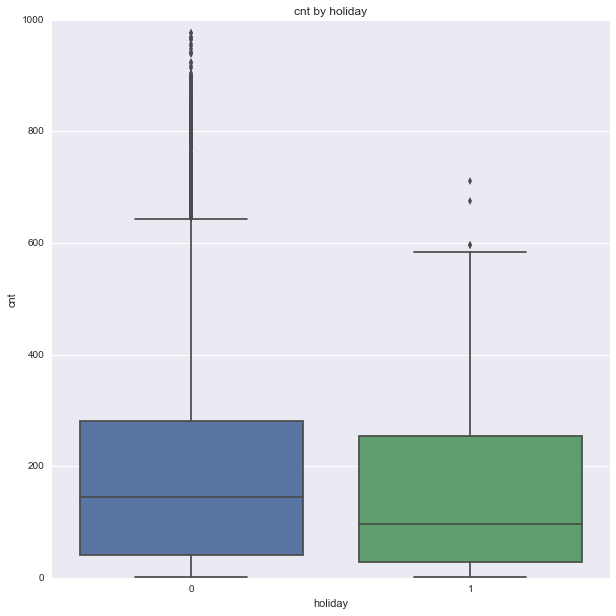

In [6]:
for col in col_list2[-2:]:        
    
    fig = plt.figure(1, figsize=(10, 10))

      
    sns.boxplot(Bdat1.cnt, groupby = Bdat1[col])

    plt.title('cnt by '+ col)

    plt.show() 
    fig.savefig('./figures/Bplot'+col) 
    plt.close()

### Scatter plots

Scatter plots  show scatter plots of selected columns in relation to each other. 
With a scatter plot matrix, it is easy to spot variables that are colinear.

Below are depicted scatter plots between each feature and the target count.

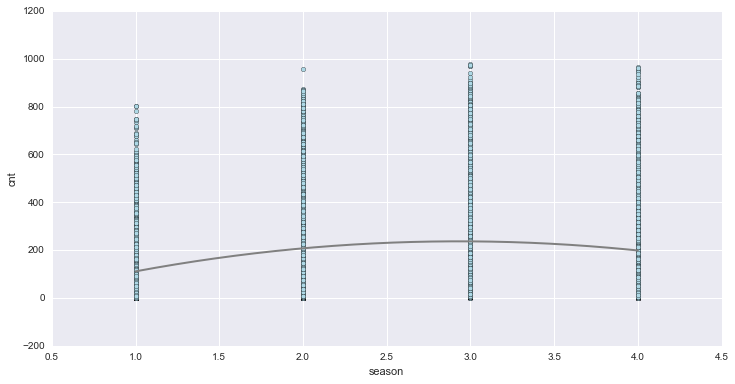

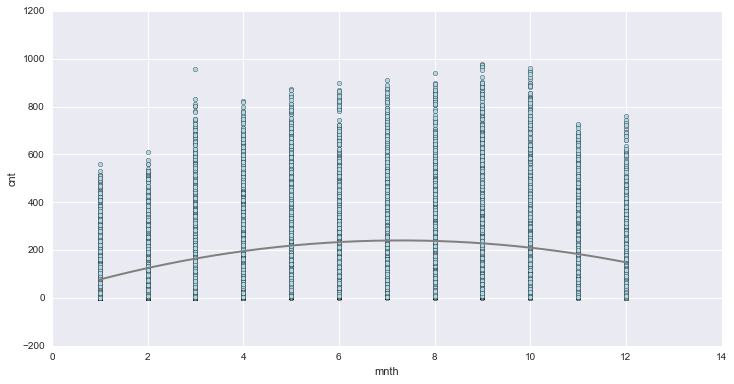

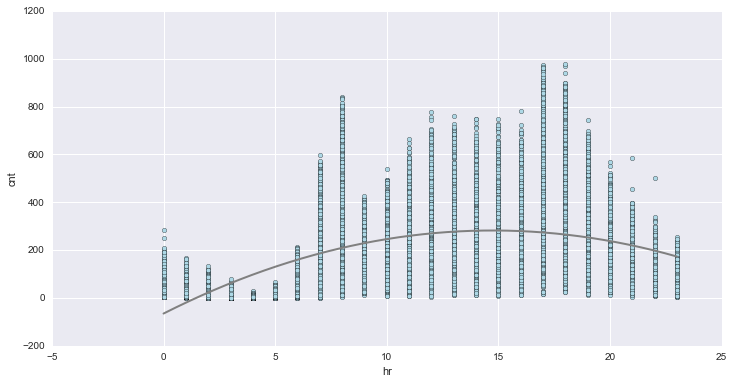

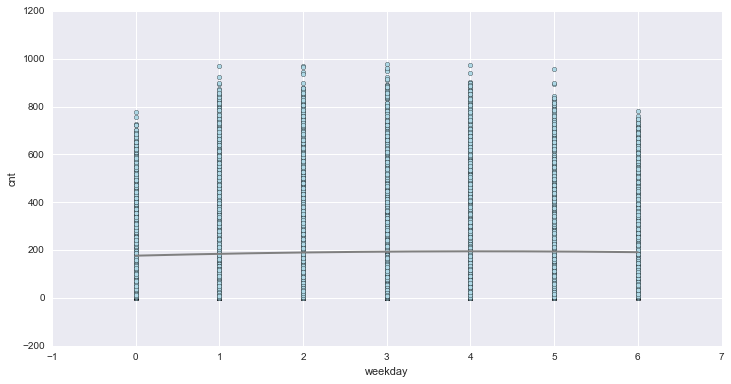

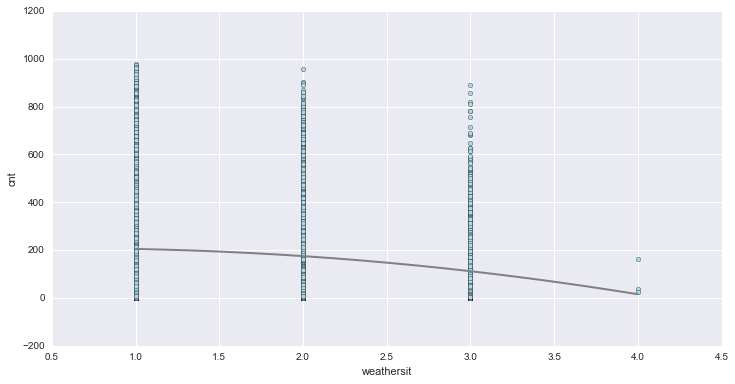

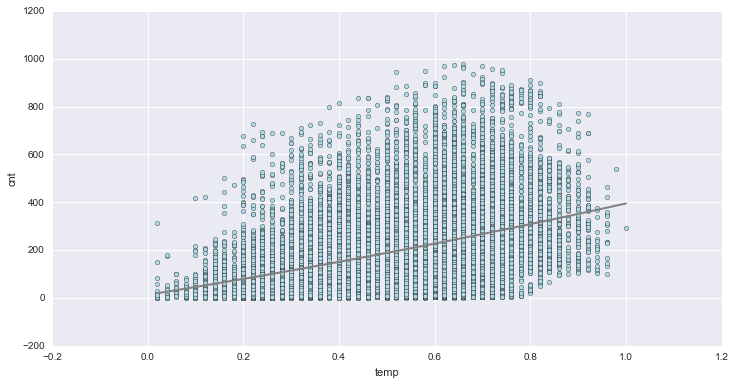

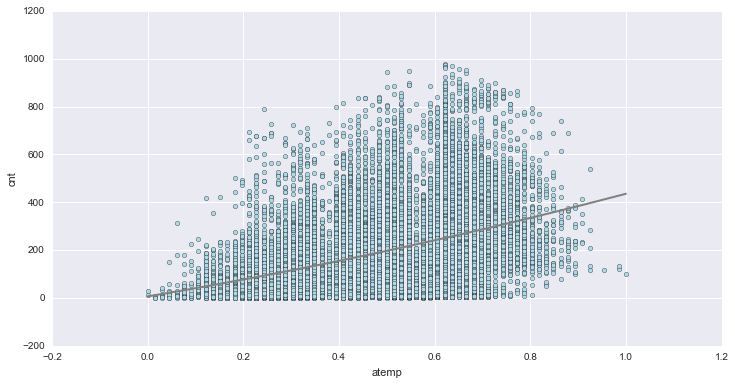

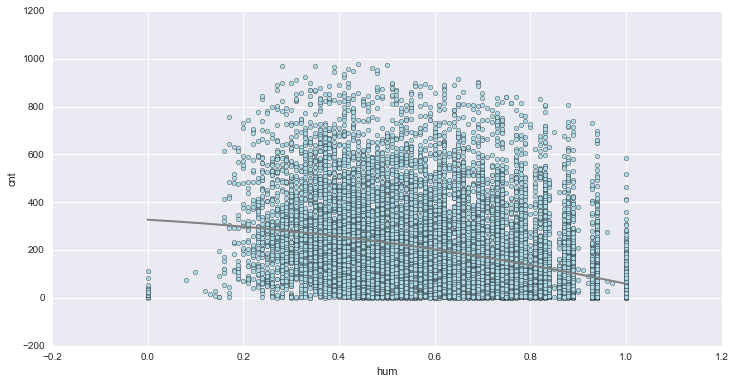

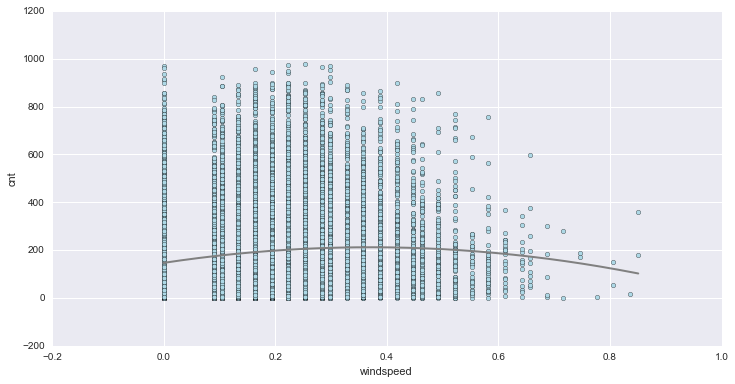

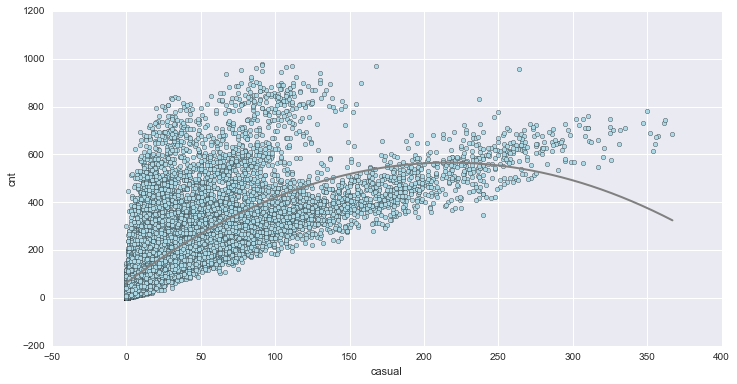

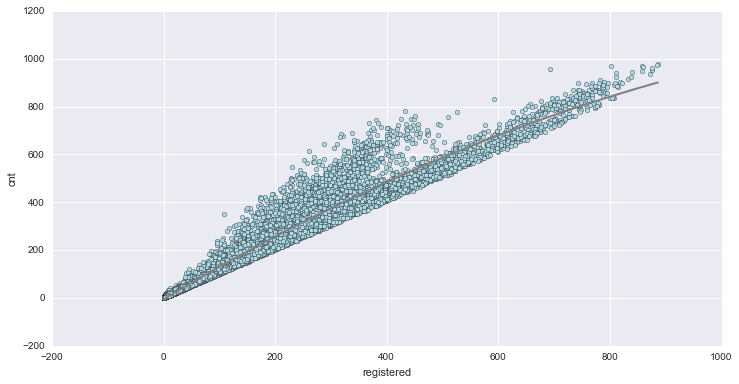

In [7]:
rm_col = ['holiday', 'yr', 'workingday']

myfuncs.scat_rplot(Bdat1.drop(rm_col, axis=1), (Bdat1.drop(rm_col, axis=1)).columns[:-1])

As can be observed on the scatter plots, there is a linear trend between the cnt column and hum, atemp, registered, temp and weathersit columns. 

The fit is curved with casual, hr, mnth, season and windspeed columns. It denotes a non linear tendency.

Now let see if squaring or cubing colum values can improve the alignement between the features and the target in the non linear cases.

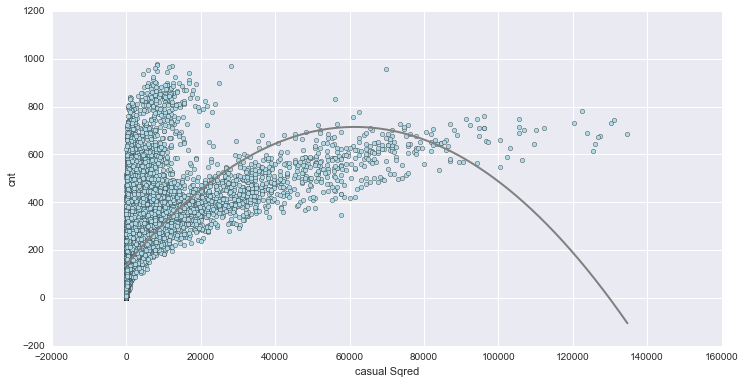

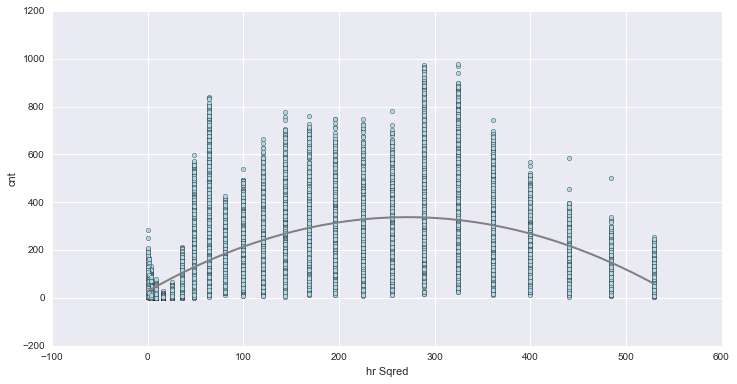

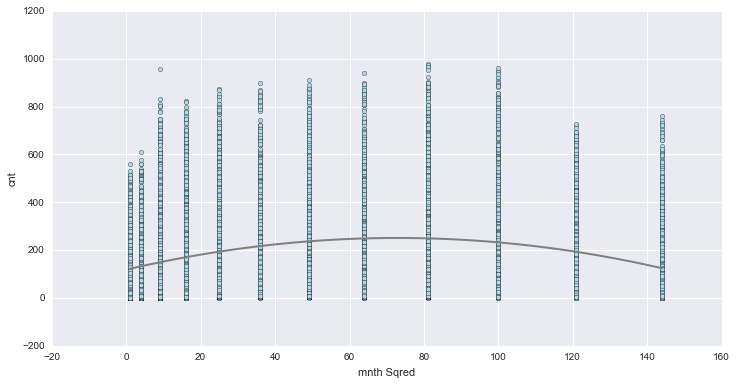

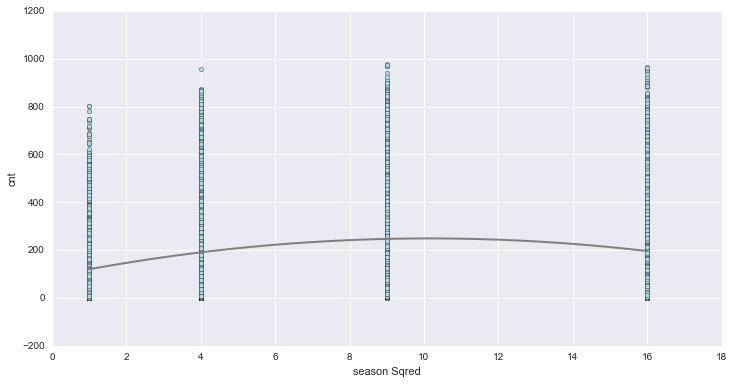

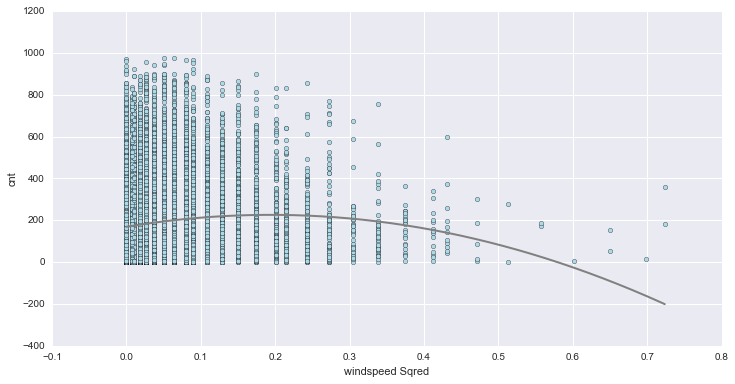

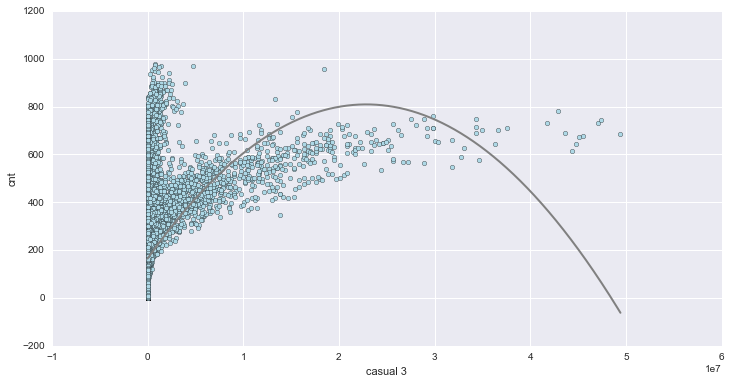

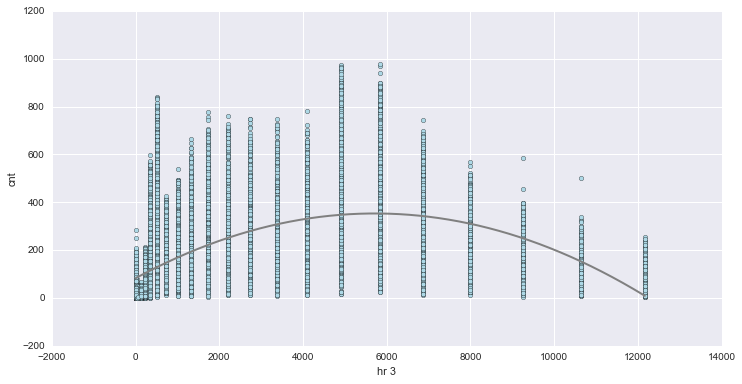

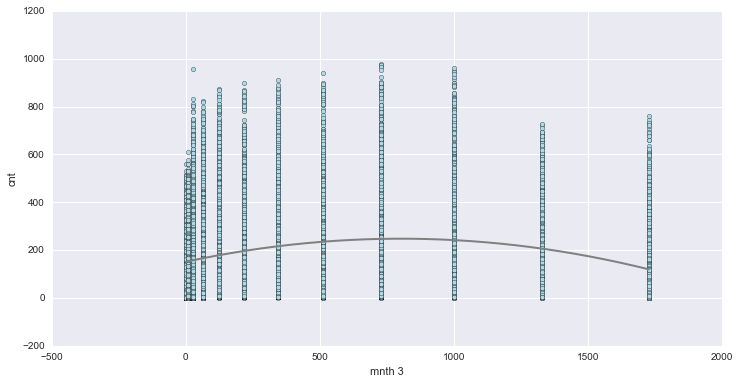

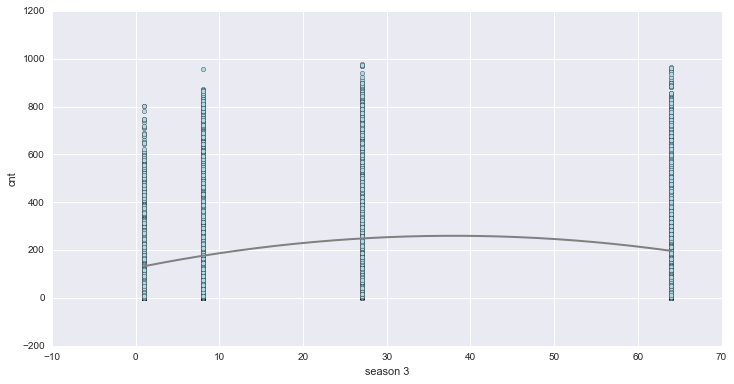

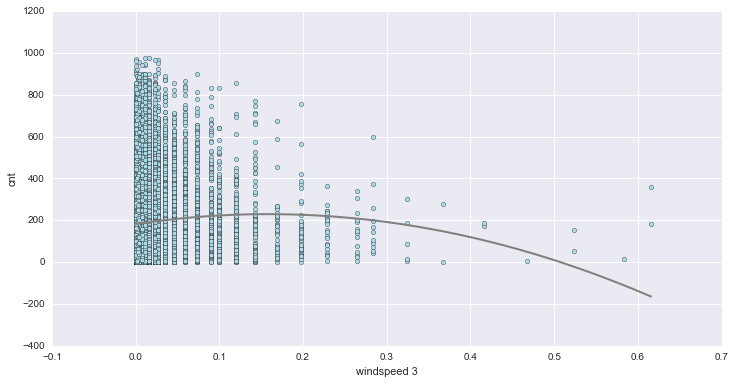

In [8]:
#==============================================================================
# Data visualisation for feature engineering
#==============================================================================

#Bdat_f = Bdat1

sqrList = ['casual','hr','mnth','season','windspeed']


sqredList = ['casual Sqred','hr Sqred','mnth Sqred','season Sqred','windspeed Sqred']

Bdat_f[sqredList] = Bdat1[sqrList]**2

cubeList = ['casual 3','hr 3','mnth 3','season 3','windspeed 3']

Bdat_f[cubeList] =  Bdat1[sqrList]**3

#Bdat_f.head()




col_listf = ['casual Sqred','hr Sqred','mnth Sqred','season Sqred','windspeed Sqred', 
            'casual 3','hr 3','mnth 3','season 3','windspeed 3']
       


myfuncs.scat_rplot(Bdat_f, col_listf)   





Squaring or cubing the features tends to increase the curves curvature. Therefore, the newly created features won't be added to the machine learning models.

### Building Machine Learning algorithms

As we would like to predict a numerical value (count of bike rentals), we will build regression algorithms.

The metrics used to evalute the algorithms performance are Mean Absolute Error, Root Mean Square Error and R2 score.

In [9]:
# Initial features
#Bdat1.head()

#==============================================================================
# Splitting target and features 
#==============================================================================


Y = Bdat1.cnt.values # target

X =  Bdat1.drop(['cnt', 'casual', 'registered'], axis=1)  #features

state = randint(1,100)

X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X,Y, test_size=0.10, random_state=state)

### Linear Regression

             0          1
0    intercept   -26.3157
1       season    19.6324
2           yr    81.6205
3         mnth  0.0400979
4           hr    7.62575
5      holiday   -21.1982
6      weekday    1.88847
7   workingday    4.33644
8   weathersit   -3.38939
9         temp     39.536
10       atemp    275.567
11         hum   -198.651
12   windspeed    44.1489


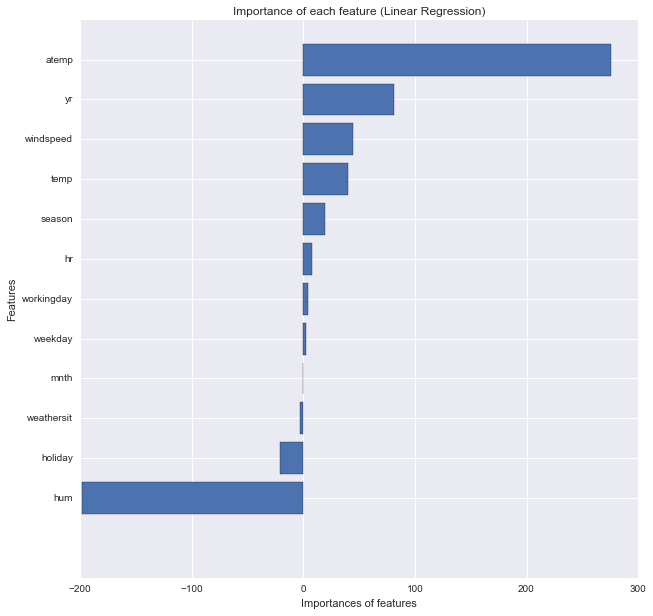

lr_MAE 106.068755412
lr_MSE 19629.1689078
lr_R2 0.404732530659


In [10]:
lm = LinearRegression()

lm.fit(X_train, Y_train)

# Looking at the coefficients

myfuncs.print_outframe(lm, X.columns)

myfuncs.plot_outframe(lm, X, 'Linear Regression')


# Evaluating the model


print ('lr_MAE',  mean_absolute_error(Y_test ,lm.predict(X_test)))
print ('lr_MSE',   mean_squared_error(Y_test ,lm.predict(X_test)))
print ('lr_R2',  r2_score(Y_test ,lm.predict(X_test)))


The linear model provides an R2 score around 0.40 on a scale between 0 and 1. It indicates of the poor peformance of the model. Besides MAE and MSE errors can be compare with the one from the other algorithms implemented below. 

As observed in the previous scatter plots visualisations, there is a non linear tendency in the data that the algorithm might not fit well.

The regression coefficients indicating importance of each feature are plotted above. 

Let try to impose a penalty term on these coefficients to see if it can improve the model (Ridge Regression).

### Ridge Regression

In [11]:
#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20]

#alpha_ridge = np.linspace(4,6,20)

rdg = Ridge() 
grid = GridSearchCV(estimator=rdg, param_grid= dict(alpha=alpha_ridge), cv = 10)

grid.fit(X_train, Y_train)


# summarize the results of the grid search
print('best_score:', grid.best_score_)
print('best_alpha:', grid.best_estimator_.alpha)

print('grid_scores =', grid.grid_scores_)


best_score: 0.38570317949114685
best_alpha: 1
grid_scores = [mean: 0.38569, std: 0.01594, params: {'alpha': 1e-15}, mean: 0.38569, std: 0.01594, params: {'alpha': 1e-10}, mean: 0.38569, std: 0.01594, params: {'alpha': 1e-08}, mean: 0.38569, std: 0.01594, params: {'alpha': 0.0001}, mean: 0.38569, std: 0.01594, params: {'alpha': 0.001}, mean: 0.38569, std: 0.01595, params: {'alpha': 0.01}, mean: 0.38569, std: 0.01595, params: {'alpha': 0.1}, mean: 0.38570, std: 0.01599, params: {'alpha': 1}, mean: 0.38565, std: 0.01607, params: {'alpha': 5}, mean: 0.38558, std: 0.01608, params: {'alpha': 10}, mean: 0.38544, std: 0.01603, params: {'alpha': 20}]


The regularisation is ineficcient, in the optimal case the error remains close to the linear model

             0          1
0    intercept   -25.5963
1       season    19.6544
2           yr    81.6152
3         mnth  0.0342921
4           hr    7.63301
5      holiday   -21.2435
6      weekday    1.87883
7   workingday    4.33286
8   weathersit   -3.48928
9         temp     57.359
10       atemp    255.177
11         hum    -198.01
12   windspeed    43.1011


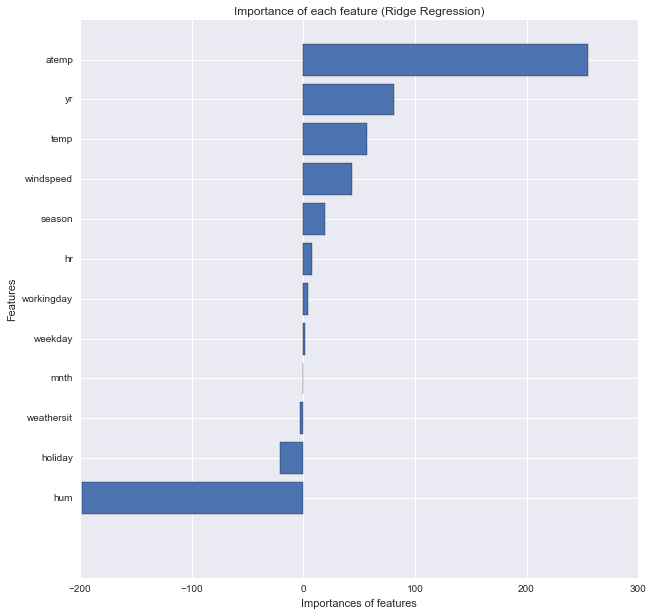

rdg_MAE 106.052947279
rdg_MSE 19617.9283888
rdg_R2 0.405073406797


In [12]:
# Check how behaves the model in the best case and on the same data

rdg = Ridge(alpha = grid.best_estimator_.alpha)
rdg.fit(X_train, Y_train)
# Looking at the coefficients

myfuncs.print_outframe(rdg, X.columns)

myfuncs.plot_outframe(rdg, X, 'Ridge Regression')

# Evaluating the model


print ('rdg_MAE',  mean_absolute_error(Y_test ,rdg.predict(X_test)))
print ('rdg_MSE',   mean_squared_error(Y_test ,rdg.predict(X_test)))
print ('rdg_R2',  r2_score(Y_test ,rdg.predict(X_test)))



As there is no regularisation, coefficients and errors remain comparable to the linear case.

The data visualization has shown that temp and atemp are highly correlated.

As these colums contains similar informations, pruning one of them might improve the learning process.

Let remove the weigthless one in the linear model and evaluate the algorithm performance.

             0          1
0    intercept   -27.9024
1       season    19.6637
2           yr    81.6369
3         mnth  0.0363611
4           hr    7.62204
5      holiday    -20.992
6      weekday    1.91389
7   workingday    4.37627
8   weathersit   -3.32539
9        atemp      319.4
10         hum   -199.073
11   windspeed    46.3696


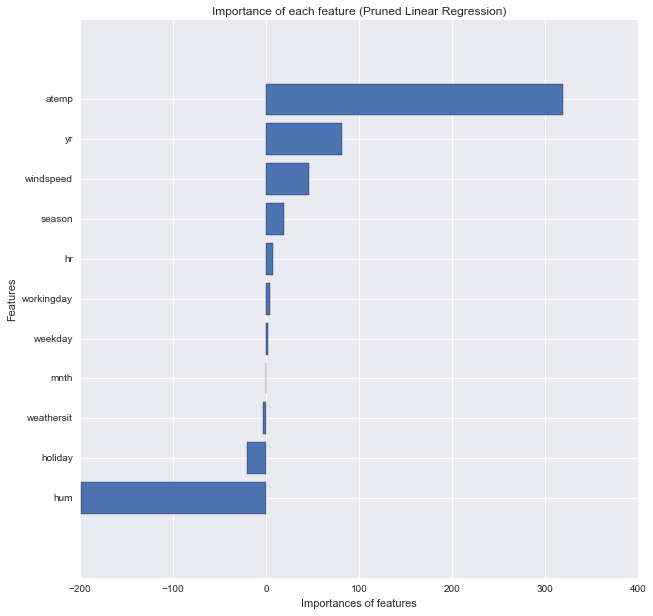

plr_MAE 106.104392239
plr_MSE 19656.6651187
plr_R2 0.403898689963


In [13]:
#==============================================================================
# Feature engineering may improve model performance
#==============================================================================

Xf =  Bdat1.drop(['cnt', 'casual', 'registered', 'temp'], axis=1)  # pruned features



X_train_f, X_test_f, Y_train_f, Y_test_f = sklearn.cross_validation.train_test_split(Xf,Y, test_size=0.10, random_state=state)


lm.fit(X_train_f, Y_train_f)

# Looking at the coefficients

myfuncs.print_outframe(lm, Xf.columns)

myfuncs.plot_outframe(lm, Xf, 'Pruned Linear Regression')



# Evaluating the model


print ('plr_MAE',  mean_absolute_error(Y_test_f ,lm.predict(X_test_f)))
print ('plr_MSE',   mean_squared_error(Y_test_f ,lm.predict(X_test_f)))
print ('plr_R2',  r2_score(Y_test_f ,lm.predict(X_test_f)))


No improvement is noticed while pruning temp (slight improvement with hum sqred?).

### Random Forest Regressor 

num_trees 1
num_trees 2
num_trees 3
num_trees 4
num_trees 5
num_trees 6
num_trees 7
num_trees 8
num_trees 9
num_trees 10
num_trees 11
num_trees 12
num_trees 13
num_trees 14
num_trees 15
num_trees 16
num_trees 17
num_trees 18
num_trees 19
num_trees 20
num_trees 21
num_trees 22
num_trees 23
num_trees 24
elapsed time for RFR optim 1497088819.395018


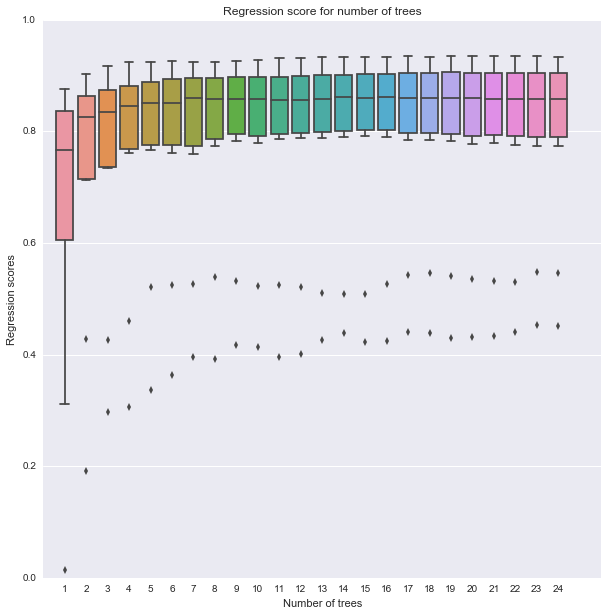

In [14]:
# Optimizing the number of trees (might take few minutes!)

scores = []

ntree = 25

tic = time.clock()

for val in range(1,ntree):
     rfr = RandomForestRegressor(n_estimators = val, random_state=11)
     validated  = cross_val_score(rfr, X, Y, 
                                  cv=10, scoring='r2')
                                  
     print ('num_trees', val)                             
     scores.append(validated)

print ('elapsed time for RFR optim', time.time() - tic)

fig = plt.figure(1, figsize=(10, 10))

ax = sns.boxplot(data=scores, orient='v')   

plt.xlim(-1, ntree)  
plt.xlabel('Number of trees')
plt.ylabel('Regression scores')
plt.title('Regression score for number of trees')
ax.set_xticklabels(np.arange(1, ntree))

plt.show()

fig.savefig('./figures/rfr_Bplot') 

For each boxplot plotted above we can notice two outliers. They correspond to test folds where the algorithm did not fit the data well. 

Globally the score tends to increase with the number of trees and remains constant around 14.

Now we will train the Random Forest Regressor with 14 trees and score the model to compare with the others.

rfr_MAE 24.8211382815
rfr_MSE 1835.14957746
rfr_R2 0.944347880954


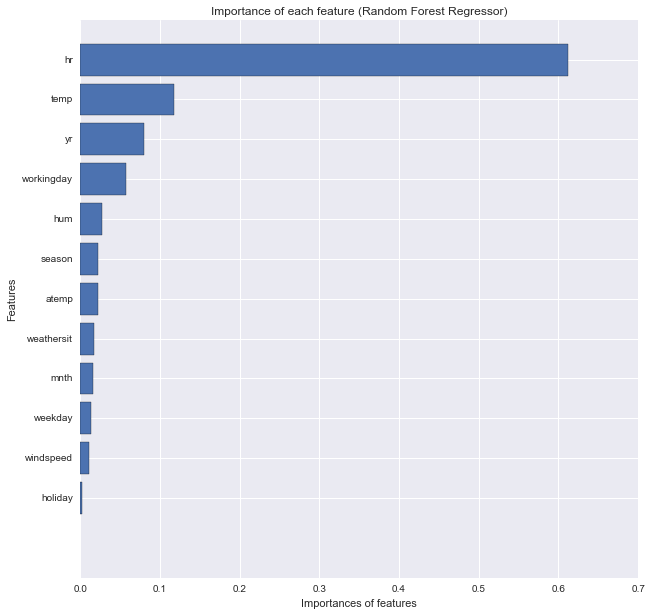

In [15]:
# print scores[14] 

rfr = RandomForestRegressor(n_estimators = 100) #14 old
rfr.fit(X_train, Y_train)



print ('rfr_MAE',  mean_absolute_error(Y_test ,rfr.predict(X_test)))
print ('rfr_MSE',   mean_squared_error(Y_test ,rfr.predict(X_test)))
print ('rfr_R2',  r2_score(Y_test ,rfr.predict(X_test)))




myfuncs.plot_outframe2(rfr, X, '1')

Random Forest allows to increase R2 score from  0.40 (linear model) up to 0.94. It is therefore, the best model for the bike rental count prediction.

Now let train the Random Forest algorithm with casual and registered as target columns separetely. 

The idea behind this choice is that unlike registered users, casual ones might behave differently. They may rent bikes temporary, for example in holidays or more often for specific seasons or months.

Splitting the problem in this way may facilitate the learning process and lead to a better accuracy.  

In [16]:
# Splitting target and features


Y_c = Bdat1.casual.values # target= casual

X_train_c, X_test_c, Y_train_c, Y_test_c = sklearn.cross_validation.train_test_split(X,Y_c, test_size=0.10, random_state=state)


rfrc = RandomForestRegressor(n_estimators = 100) #RandomForestRegressor(n_estimators = 14)
rfrc.fit(X_train_c, Y_train_c)
#rfrc.fit(X_train_c, np.sqrt(Y_train_c))
#rfrc.fit(X_train_c, np.log(Y_train_c))


print ('rfr_MAE casual',  mean_absolute_error(Y_test_c ,rfrc.predict(X_test_c)))
print ('rfr_MSE casual',   mean_squared_error(Y_test_c ,rfrc.predict(X_test_c)))
print ('rfr_R2  causal',  r2_score(Y_test_c ,rfrc.predict(X_test_c)))
 
    
#print ('rfr_MAE casual',  mean_absolute_error(Y_test_c , (rfrc.predict(X_test_c))**2))
#print ('rfr_MSE casual',   mean_squared_error(Y_test_c ,(rfrc.predict(X_test_c))**2))
#print ('rfr_R2 casual',  r2_score(Y_test_c , (rfrc.predict(X_test_c))**2))    


Y_d = Bdat1.registered.values # target= registered

X_train_d, X_test_d, Y_train_d, Y_test_d = sklearn.cross_validation.train_test_split(X,Y_d, test_size=0.10, random_state=state)




rfrd = RandomForestRegressor(n_estimators = 100) #RandomForestRegressor(n_estimators = 14)

rfrd.fit(X_train_d, Y_train_d)

#rfrd.fit(X_train_d, np.sqrt(Y_train_d))


print ('rfr_MAE registered',  mean_absolute_error(Y_test_d ,rfrd.predict(X_test_d)))
print ('rfr_MSE registered',   mean_squared_error(Y_test_d ,rfrd.predict(X_test_d)))
print ('rfr_R2 registered',  r2_score(Y_test_d ,rfrd.predict(X_test_d)))

#print ('rfr_MAE registered',  mean_absolute_error(Y_test_d , (rfrd.predict(X_test_d))**2))
#print ('rfr_MSE registered',   mean_squared_error(Y_test_d ,(rfrd.predict(X_test_d))**2))
#print ('rfr_R2 registered',  r2_score(Y_test_d , (rfrd.predict(X_test_d))**2))    
    

# Predict count error

#Y = Bdat1.cnt.values # target= casual

#X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X,Y, test_size=0.10, random_state=state)

print ('rfr_MAE count',  mean_absolute_error(Y_test , rfrc.predict(X_test)+rfrd.predict(X_test)))
print ('rfr_MSE count',   mean_squared_error(Y_test , rfrc.predict(X_test) + rfrd.predict(X_test)))
print ('rfr_R2 count',  r2_score(Y_test , rfrc.predict(X_test) +rfrd.predict(X_test)))

#print ('rfr_MAE count',  mean_absolute_error(Y_test , rfrc.predict(X_test)**2+rfrd.predict(X_test)))
#print ('rfr_MSE count',   mean_squared_error(Y_test , rfrc.predict(X_test)**2 + rfrd.predict(X_test)))
#print ('rfr_R2 count',  r2_score(Y_test , rfrc.predict(X_test)**2 +rfrd.predict(X_test)))


rfr_MAE casual 8.13569601074
rfr_MSE casual 198.473614402
rfr_R2  causal 0.911612566853
rfr_MAE registered 19.5449597238
rfr_MSE registered 1259.44239301
rfr_R2 registered 0.945099974482
rfr_MAE count 23.8251726122
rfr_MSE count 1770.56656314
rfr_R2 count 0.946306403379



The error obtained is slightly decreased by splitting casual and registered users 

Let compare the true count and the predicted count

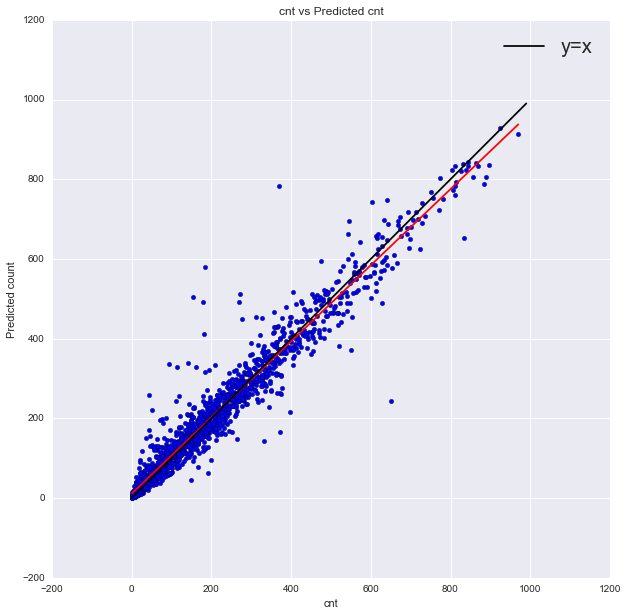

In [17]:
fig = plt.figure(1, figsize=(10, 10))
    
plt.scatter(Y_test , rfrc.predict(X_test)+rfrd.predict(X_test))
plt.xlabel('cnt')
plt.ylabel('Predicted count')
plt.title('cnt vs Predicted cnt')

plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, rfrc.predict(X_test)+rfrd.predict(X_test), 1))(np.unique(Y_test)), 'r')

plt.plot(np.arange(0,1000, 10), np.arange(0,1000, 10), 'k', label= 'y=x')

plt.legend(fontsize=20)

plt.show()

fig.savefig('./figures/Tcnt_vs_Pcnt')
plt.close()

As can be seen on the scatter plot, the model fit well the count in the the first half of the count range (0 to 500), but it slightly underestimates the ones above this range.

In [18]:
len(X_train_c) # to check the number of samples 

15641

In [19]:
np.log2(12) 
np.sqrt(12) #in fact same => tuning by hands

3.4641016151377544

As the defaut min_samples_leaf was employed without overfitting we ll not tune this parameter anymore

Verbose controls the verbosity: the higher, the more messages.

### Tuning the Random Forest

In [20]:
#rmsele_scorer = make_scorer(myfuncs.rmsele, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Parameter Optimisation with grid search

#tuned_parameters = [{'max_features': ['sqrt', 'log2', 'auto'], 'min_samples_leaf': [20, 40, 60, 100]}]
tuned_parameters = [{'max_features': [3, 4, 5, 6, 7, 8]}]

rfc_tune =  GridSearchCV(RandomForestRegressor(n_jobs=1, n_estimators = 100), tuned_parameters, cv=10, verbose=2, scoring=mse_scorer).fit(X_train_c, Y_train_c)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.8s
[CV] max_features=3 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ......................................... max_features=3 -   1.7s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.9s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.7s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.8s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.7s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.7s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.7s
[CV] max_features=3 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.7min finished


In [21]:
print ('Best Parameters:')
print (rfc_tune.best_estimator_)
#print (rfc_tune.grid_scores_)

Best Parameters:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


max_features = 6 has been changed

In [22]:
#Evaluationg the performance

rfrc = RandomForestRegressor(n_estimators = 100, max_features= 6) #RandomForestRegressor(n_estimators = 14)
rfrc.fit(X_train_c, Y_train_c)


print ('rfr_MAE casual',  mean_absolute_error(Y_test_c ,rfrc.predict(X_test_c)))
print ('rfr_MSE casual',   mean_squared_error(Y_test_c ,rfrc.predict(X_test_c)))
print ('rfr_R2  causal',  r2_score(Y_test_c ,rfrc.predict(X_test_c)))
 

rfr_MAE casual 8.00143728423
rfr_MSE casual 190.788111599
rfr_R2  causal 0.915035197449


old
rfr_MAE casual 8.40285481396
rfr_MSE casual 205.047961071
rfr_R2  causal 0.914893801935

The MSE is reduced

In [23]:
rfd_tune =  GridSearchCV(RandomForestRegressor(n_jobs=1, n_estimators = 100), tuned_parameters, cv=10, verbose=2, scoring=mse_scorer).fit(X_train_d, Y_train_d)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   2.0s
[CV] max_features=3 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ......................................... max_features=3 -   1.9s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.9s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   2.0s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.8s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.9s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   1.9s
[CV] max_features=3 ..................................................
[CV] ......................................... max_features=3 -   2.1s
[CV] max_features=3 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.9min finished


In [24]:
print ('Best Parameters:')
print (rfd_tune.best_estimator_)
#print (rfc_tune.grid_scores_)

Best Parameters:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


again lets change the max_features to 8

In [25]:
rfrd = RandomForestRegressor(n_estimators = 100, max_features= 8) #RandomForestRegressor(n_estimators = 14)

rfrd.fit(X_train_d, Y_train_d)

#rfrd.fit(X_train_d, np.sqrt(Y_train_d))


print ('rfr_MAE registered',  mean_absolute_error(Y_test_d ,rfrd.predict(X_test_d)))
print ('rfr_MSE registered',   mean_squared_error(Y_test_d ,rfrd.predict(X_test_d)))
print ('rfr_R2 registered',  r2_score(Y_test_d ,rfrd.predict(X_test_d)))

rfr_MAE registered 18.9222758918
rfr_MSE registered 1156.40463779
rfr_R2 registered 0.949591466449


old
rfr_MAE registered 19.1539063784
rfr_MSE registered 1008.68780969
rfr_R2 registered 0.955340759827

The MSE is again reduced...

In [26]:
#final predictions

print ('rfr_MAE count',  mean_absolute_error(Y_test , rfrc.predict(X_test)+rfrd.predict(X_test)))
print ('rfr_MSE count',   mean_squared_error(Y_test , rfrc.predict(X_test) + rfrd.predict(X_test)))
print ('rfr_R2 count',  r2_score(Y_test , rfrc.predict(X_test) +rfrd.predict(X_test)))

rfr_MAE count 23.2502498082
rfr_MSE count 1642.52462452
rfr_R2 count 0.95018935946


In [27]:
#old 

#rfr_MAE count 23.4645941421
#rfr_MSE count 1431.37273776
#rfr_R2 count 0.95568300943

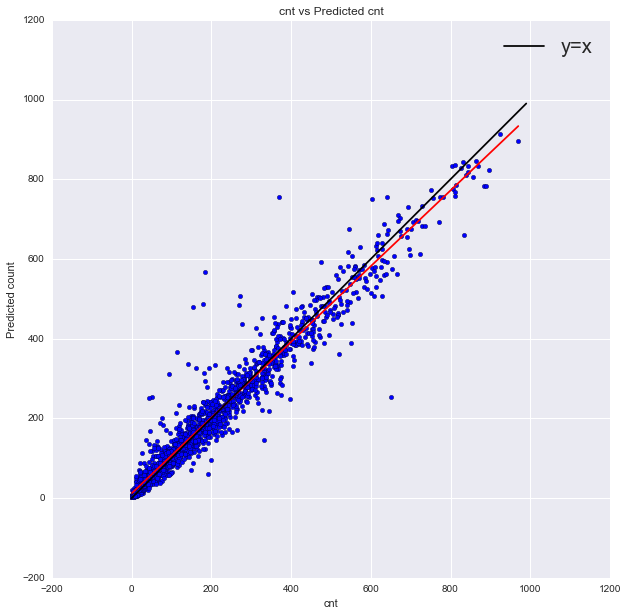

In [28]:
fig = plt.figure(1, figsize=(10, 10))
    
plt.scatter(Y_test , rfrc.predict(X_test)+rfrd.predict(X_test))
plt.xlabel('cnt')
plt.ylabel('Predicted count')
plt.title('cnt vs Predicted cnt')

plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, rfrc.predict(X_test)+rfrd.predict(X_test), 1))(np.unique(Y_test)), 'r')

plt.plot(np.arange(0,1000, 10), np.arange(0,1000, 10), 'k', label= 'y=x')

plt.legend(fontsize=20)

plt.show()

fig.savefig('./figures/Tcnt_vs_Pcnt')
plt.close()

More investigations can be done on the the highest counts in such way  to improve the accuracy of the algorithm. 

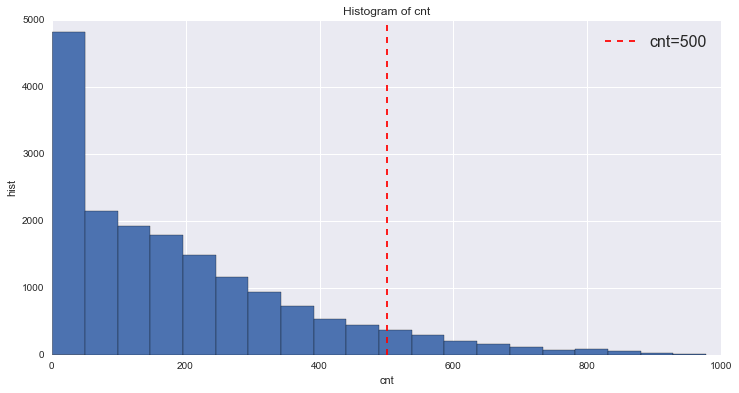

Approximative percentage of count below five hundred 91.9673168767


In [29]:
fig = plt.figure(figsize = (12,6))
fig.clf()

values, bins, _ = plt.hist(Y, bins = 20)
plt.vlines(x=500, ymin=0, ymax=5000, color='r',linestyles = 'dashed',label='cnt=500')
plt.title('Histogram of cnt')
plt.xlabel('cnt') 
plt.ylabel('hist')
plt.legend(fontsize=16)

  
plt.show() 
   
plt.close()

ki = [i for i in range(0, len(bins)) if bins[i] <500][-1] #Take the index of the last bin before 500

print ('Approximative percentage of count below five hundred', 100*values[:ki].sum()/values.sum())


Only 8% of the data have a count above 500. These counts probably correspond to the potential outliers 
observed on the boxplots above. They were found to be correlated with holidays and  specific range of hours. 

The future task will be to think of an efficient strategy to handle these high values. 

Besides, I would have like to check the results obtained with Support Vector Regression  and compare it with the other algorithms. Unfortunately, the cost of optimizing the regression parameters (either with RandomizedSearchCV or GridSearchCV) is high (piece of code depicted below). 

A smarter way of optimizing SVR on this data set still needs to be find.

Comparing casual and registered users 

C:\Users\Dekou\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


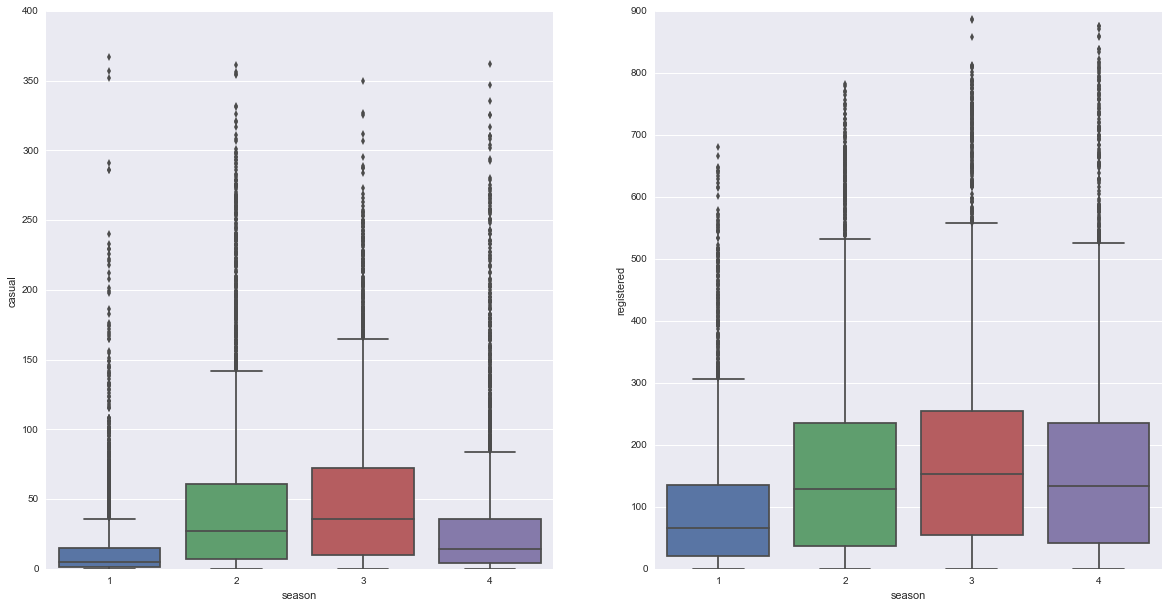

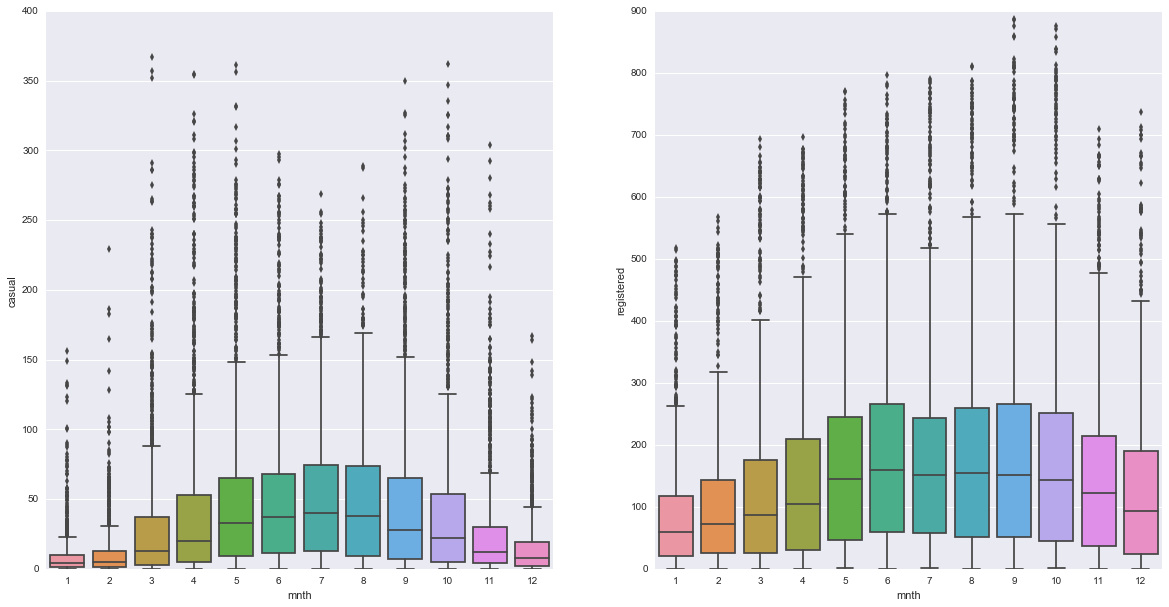

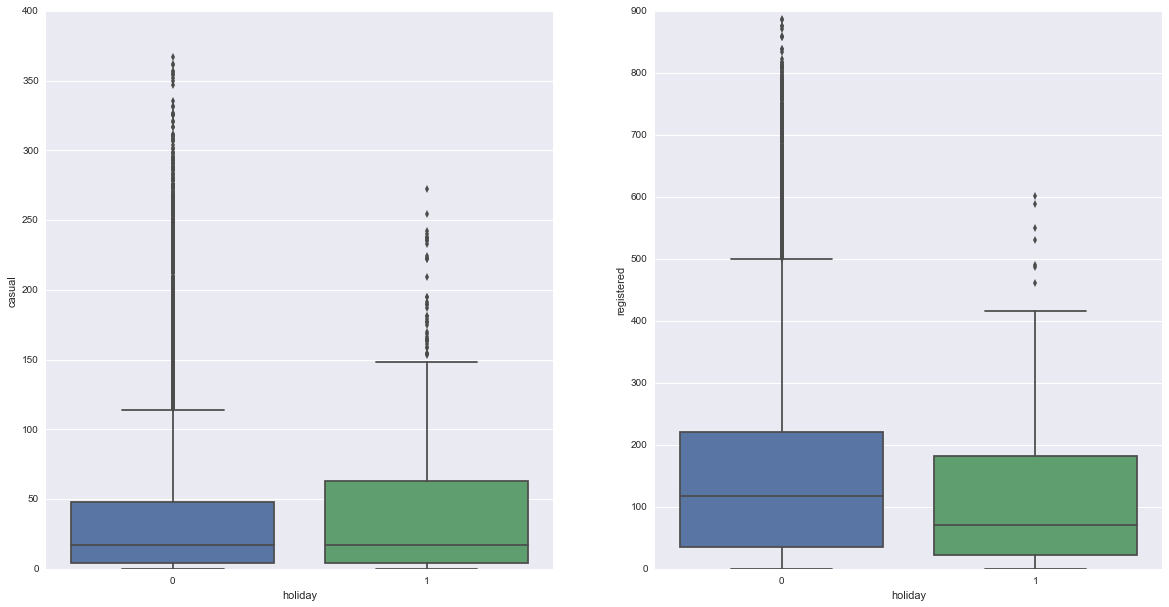

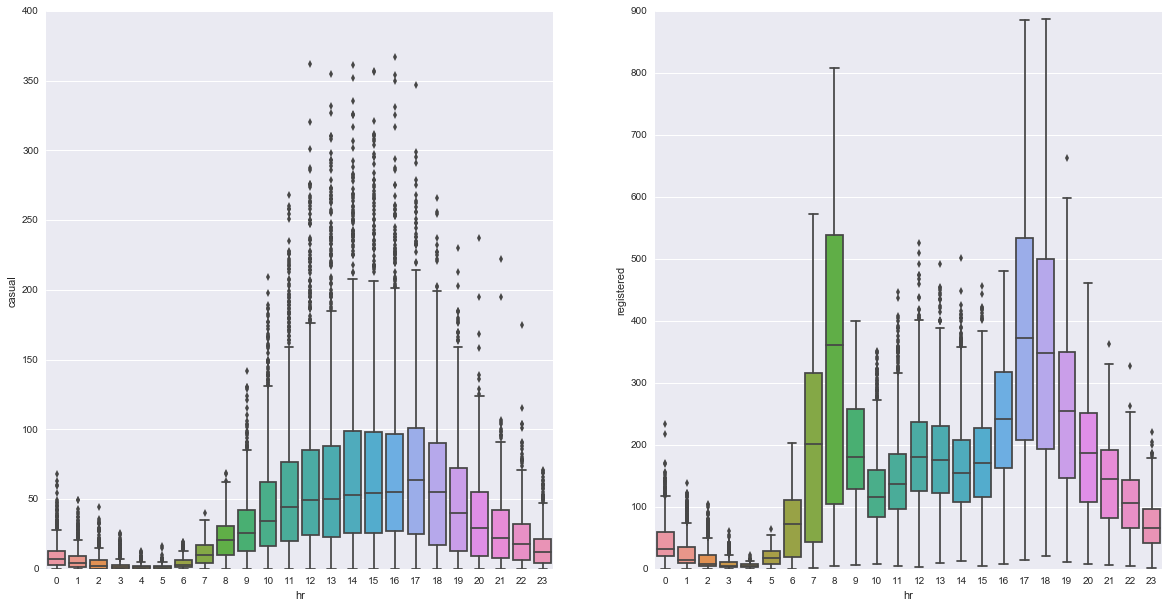

In [30]:

col_list3 = ['season', 'mnth',  'holiday', 'hr']  
  

    
    
    
for col in col_list3:        
    
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))


    sns.boxplot(Bdat1.casual, groupby = Bdat1[col], ax= ax1)
    
    sns.boxplot(Bdat1.registered, groupby = Bdat1[col], ax= ax2)
    

    plt.show() 
    fig.savefig('./figures/Bplot_c_'+col) 
    plt.close()




In [31]:
'''
# Support  vector regression 


svr = SVR(C=1) 

params_svr = {'C': uniform (1e0, 1e4),
              'kernel': ['linear']}


#params_svr = {'C': uniform (1, 100),
#              'gamma': uniform(0,50),
#              'kernel': ['rbf']} 
              
              
#params_svr = {'C': uniform (1e0, 1e4),
#              'degree': [2, 5],
#             'kernel': ['poly'],
#             'coef0': [0.1]}              

           
grid = RandomizedSearchCV(svr, param_distributions= params_svr , n_iter=1)


grid.fit(X_train, Y_train)
'''

"\n# Support  vector regression \n\n\nsvr = SVR(C=1) \n\nparams_svr = {'C': uniform (1e0, 1e4),\n              'kernel': ['linear']}\n\n\n#params_svr = {'C': uniform (1, 100),\n#              'gamma': uniform(0,50),\n#              'kernel': ['rbf']} \n              \n              \n#params_svr = {'C': uniform (1e0, 1e4),\n#              'degree': [2, 5],\n#             'kernel': ['poly'],\n#             'coef0': [0.1]}              \n\n           \ngrid = RandomizedSearchCV(svr, param_distributions= params_svr , n_iter=1)\n\n\ngrid.fit(X_train, Y_train)\n"